In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

2020-01-09 23:51:09.062 | INFO     | python_utilities.loader:Glob:57 - 2498 files found at /home/yyr/data/ocr/XO/all/


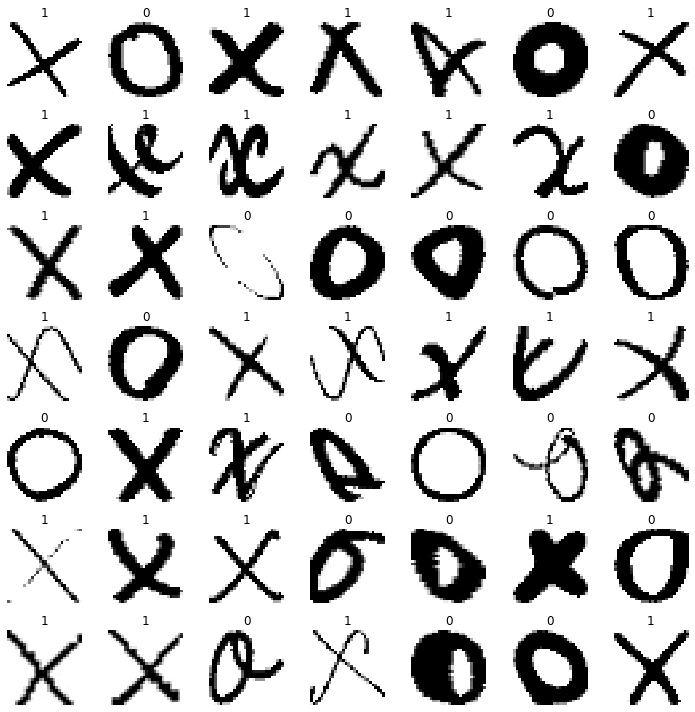

In [2]:
from torch.utils.data import DataLoader, Dataset
import sys; sys.path.append('/home/yyr/')
from python_utilities.loader import *

import imgaug as ia
from imgaug import augmenters as iaa

tfm = iaa.Sequential([iaa.Resize(28), iaa.Fliplr(p=0.5), iaa.Flipud(p=0.5)])

class XO(Dataset):
    def __init__(self, folder):
        self.files = Glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(read(f))
        cl = stem(f).split('@')[0] == 'x'
        return torch.tensor(im/255).to(device).float()[None], torch.tensor([cl]).float().to(device)
        
data = XO('/home/yyr/data/ocr/XO/all/')
n = 7
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    ix = randint(1000)
    im, label = data[ix]
    show(im.cpu()[0], title=str(label.int().item()), ax=axis)
plt.tight_layout()
plt.show()

In [3]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=15, bias=False),
        # nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(16, 2, kernel_size=7, bias=False),
        nn.AdaptiveAvgPool2d(1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(2, 1),
        nn.Sigmoid(),
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]           3,600
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3              [-1, 2, 8, 8]           1,568
 AdaptiveAvgPool2d-4              [-1, 2, 1, 1]               0
              ReLU-5              [-1, 2, 1, 1]               0
           Flatten-6                    [-1, 2]               0
            Linear-7                    [-1, 1]               3
           Sigmoid-8                    [-1, 1]               0
Total params: 5,171
Trainable params: 5,171
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.02
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


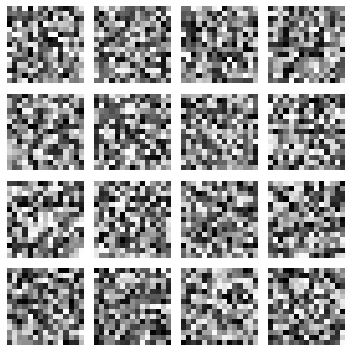

In [4]:
(cnn1_w,), (cnn2_w,), (lin_w,) = [(layer.weight.data,) for layer in list(model.children()) if hasattr(layer, 'weight')]

n = int(np.sqrt(cnn1_w.shape[0]))
fig, ax = plt.subplots(n, n, figsize=(5,5))
for ix, axis in enumerate(ax.flat):
    show(cnn1_w[ix,0].cpu(), ax=axis)
plt.tight_layout()
plt.show()

In [5]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct[0]


In [6]:
from torch.utils.data import DataLoader, TensorDataset
trn_dl = DataLoader(XO('/home/yyr/data/ocr/XO/all/'), batch_size=32, drop_last=True)
model, loss_fn, optimizer = get_model()

train_loss, trn_acc = [], []

for epoch in range(10):
    N_trn = len(trn_dl)
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_loss, corrects = train_batch(x, y, model, optimizer, loss_fn)
        train_loss.append(batch_loss)
        train_acc.extend(corrects.tolist())
        print(f'{ix}/{N_trn}, Loss: {batch_loss:.3f}', end='\r')

    print(f'Epoch: {epoch+1:3d}, Train Loss: {np.mean(train_loss):.3f}, Train Acc: {np.mean(train_acc)*100:.2f}%', end='\r')

2020-01-09 23:51:12.064 | INFO     | python_utilities.loader:Glob:57 - 2498 files found at /home/yyr/data/ocr/XO/all/


In [7]:
model(trn_dl.dataset[0][0][None])

tensor([[0.3596]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [8]:
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(15, 15), stride=(1, 1), bias=False)
  (1): ReLU()
  (2): Conv2d(16, 2, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (3): AdaptiveAvgPool2d(output_size=1)
  (4): ReLU()
  (5): Flatten()
  (6): Linear(in_features=2, out_features=1, bias=True)
  (7): Sigmoid()
)

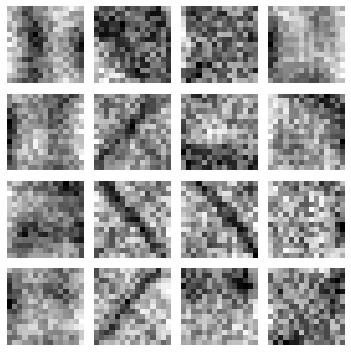

In [9]:
(cnn1_w,), (cnn2_w,), (lin_w,) = [(layer.weight.data,) for layer in list(model.children()) if hasattr(layer, 'weight')]

n = int(np.sqrt(cnn1_w.shape[0]))
fig, ax = plt.subplots(n, n, figsize=(5,5))
for ix, axis in enumerate(ax.flat):
    show(cnn1_w[ix,0].cpu(), ax=axis)
plt.tight_layout()
plt.show()

/home/yyr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


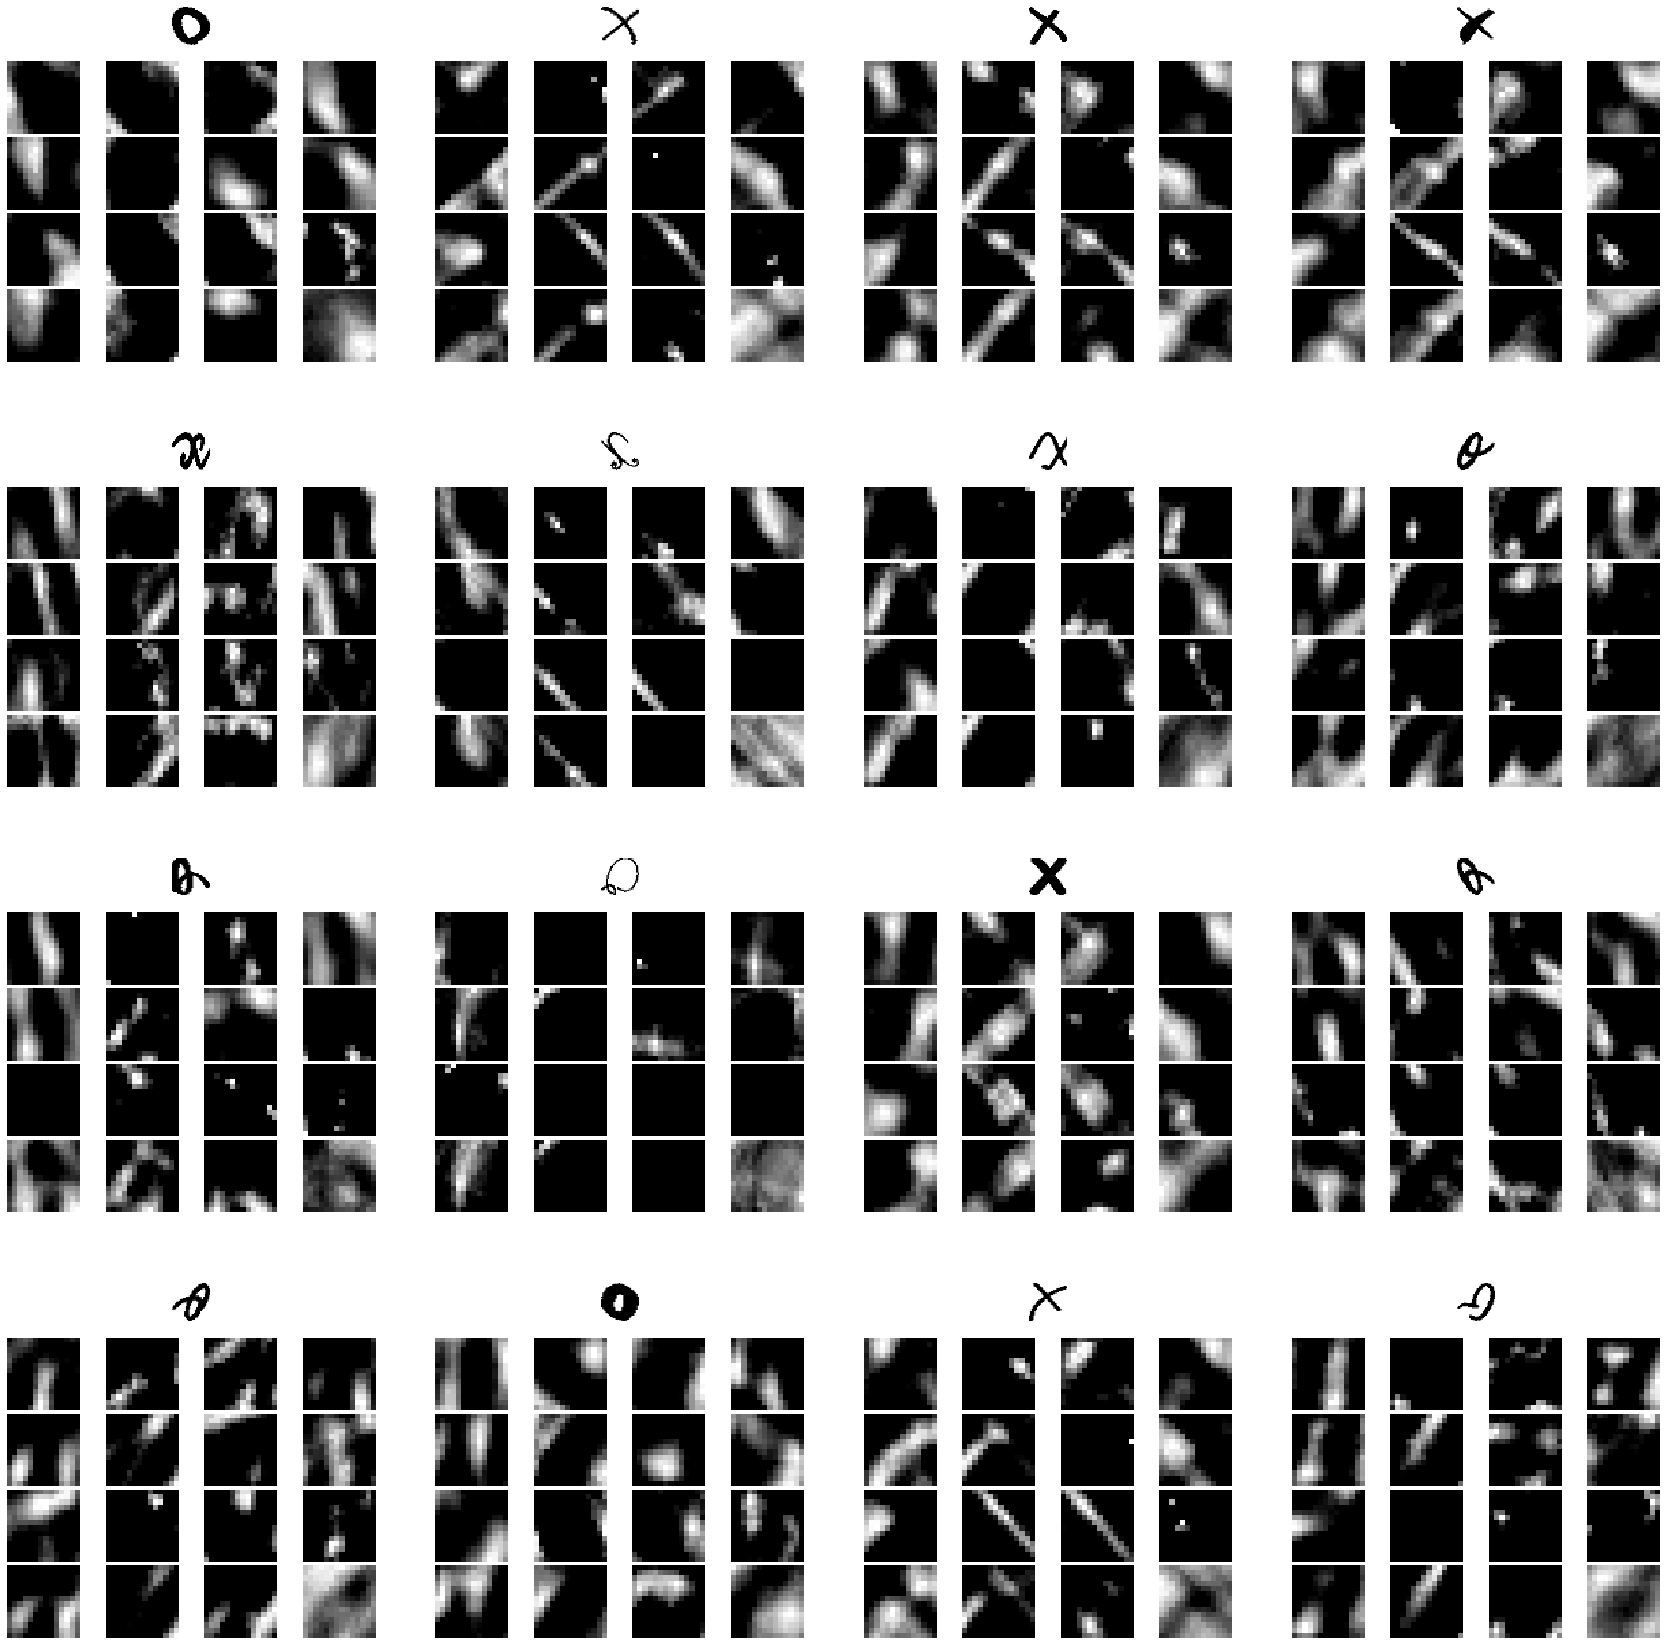

In [10]:
import matplotlib.gridspec as gridspec

first_layer = nn.Sequential(*list(model.children())[:2])

fig11 = plt.figure(figsize=(30, 30), constrained_layout=False)
# gridspec inside gridspec
outer_grid = fig11.add_gridspec(4, 4, wspace=0.1, hspace=0.2)
axes = []
for i in range(16):
    im, c = trn_dl.dataset[randint(100)]
    intermediate_output = first_layer(im[None])[0].detach()
    
    inner_item = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1,8],
                    subplot_spec=outer_grid[i], wspace=0.0, hspace=0.1)
    
    ax = plt.Subplot(fig11, inner_item[0])
    ax.imshow(im[0].cpu(), cmap='gray')
    ax.set_axis_off()
    fig11.add_subplot(ax)
    
    inner_cells = gridspec.GridSpecFromSubplotSpec(4, 4,
            subplot_spec=inner_item[1], wspace=0.05, hspace=0.05)
    for ix in range(16):
        bx = plt.Subplot(fig11, inner_cells[ix])
        bx.imshow(intermediate_output[ix].cpu(), cmap='gray')
        bx.set_axis_off()
        fig11.add_subplot(bx)
plt.tight_layout()
plt.show()

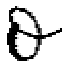

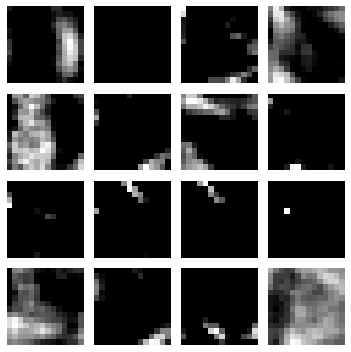

In [11]:
im, c = trn_dl.dataset[0]
show(im[0].cpu(), sz=1)

first_layer = nn.Sequential(*list(model.children())[:2])

intermediate_output = first_layer(im[None])[0].detach()

n = int(np.sqrt(cnn1_w.shape[0]))
fig, ax = plt.subplots(n, n, figsize=(5,5))
for ix, axis in enumerate(ax.flat):
    show(intermediate_output[ix].cpu(), ax=axis)
plt.tight_layout()
plt.show()

first_layer = list(model.children())[:3]

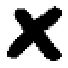

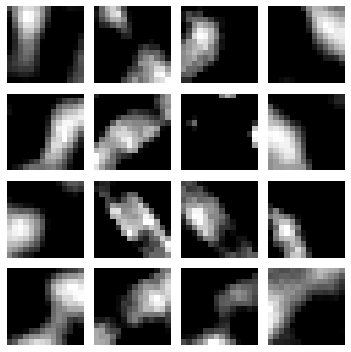

In [12]:
im, c = trn_dl.dataset[10]
show(im[0].cpu(), sz=1)

first_layer = nn.Sequential(*list(model.children())[:2])

intermediate_output = first_layer(im[None])[0].detach()

n = int(np.sqrt(cnn1_w.shape[0]))
fig, ax = plt.subplots(n, n, figsize=(5,5))
for ix, axis in enumerate(ax.flat):
    show(intermediate_output[ix].cpu(), ax=axis)
plt.tight_layout()
plt.show()


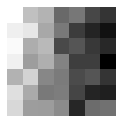

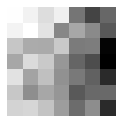

In [13]:
show(cnn2_w[0,0].cpu(), sz=2)
show(cnn2_w[1,0].cpu(), sz=2)